# Análise Exploratória de Dados de TDM

## Utils

Aqui armazenamos as funções utilizadas nas análises dos dados.

In [1]:
import matplotlib.pyplot as plt

def plot_data(df_list, legend, y_data):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    for df in df_list:
        plt.plot(df["Tempo (UTC)"], df[y_data[0]], "+")
    plt.legend(legend)
    plt.title("RA vs Tempo (UTC)")
    plt.subplot(1, 2, 2)
    for df in df_list:
        plt.plot(df["Tempo (UTC)"], df[y_data[1]], "+")
    plt.title("DEC vs Tempo (UTC)")
    plt.show()

In [2]:
import pandas as pd
from src.tracking_data_message.tracking_data_message import *

def filter_raw_data(df_raw:pd.DataFrame,df_fit = None):
    if df_fit is None:
        _, _, df_fit = fit_radec_tdm_data(df_raw, 3)
    std_ra = df_fit.describe().loc['std','Desvio RA (%)']
    mean_ra = df_fit.describe().loc['mean','Desvio RA (%)']
    third_quarter_ra = df_fit.describe().loc['75%','Desvio RA (%)']
    std_dec = df_fit.describe().loc['std','Desvio DEC (%)']
    mean_dec = df_fit.describe().loc['mean','Desvio DEC (%)']
    third_quarter_dec = df_fit.describe().loc['75%','Desvio DEC (%)']
    filter = (abs(df_fit['Desvio RA (%)'] - mean_ra) < 1.0*std_ra) & (abs(df_fit['Desvio DEC (%)'] - mean_dec) < 1.0*std_dec)
    # filter = (df_fit['Desvio RA (%)'] < third_quarter_ra) & (df_fit['Desvio DEC (%)'] < third_quarter_dec)
    # filter = (df_fit['Desvio RA (deg)'] < 0.25) & (df_fit['Desvio DEC (deg)'] < 0.25)
    time_filtered = df_fit[filter]['Tempo[s]']
    return df_raw.loc[df_raw['Tempo[s]'].isin(time_filtered)]

In [3]:
import pandas as pd
import numpy as np

def compare_radec_data(poly_ra, poly_dec, df_referencia: pd.DataFrame, x_max: float):

    desvio_ra = []
    desvio_dec = []
    desvio_ra_deg = []
    desvio_dec_deg = []

    for index, row in df_referencia.iterrows():
        x = row["Tempo[s]"]
        if x <= x_max:
            ra = row["RA[deg]"]
            dec = row["DEC[deg]"]
            desvio_ra_deg.append(np.abs(ra - poly_ra(x)))
            desvio_dec_deg.append(np.abs(dec - poly_dec(x)))
            desvio_ra.append(100 * np.abs((ra - poly_ra(x)) / ra))
            desvio_dec.append(100 * np.abs((dec - poly_dec(x)) / dec))

    dados_fit = {
        "Desvio RA (%)": desvio_ra,
        "Desvio DEC (%)": desvio_dec,
        "Desvio RA (deg)": desvio_ra_deg,
        "Desvio DEC (deg)": desvio_dec_deg,
    }

    df_fit = pd.DataFrame(data=dados_fit)

    # Desvios para RA
    median_ra = np.median(df_fit["Desvio RA (%)"])
    mean_ra = np.mean(df_fit["Desvio RA (%)"])
    std_ra = np.std(df_fit["Desvio RA (%)"])

    # Desvios para DEC
    median_dec = np.median(df_fit["Desvio DEC (%)"])
    mean_dec = np.mean(df_fit["Desvio DEC (%)"])
    std_dec = np.std(df_fit["Desvio DEC (%)"])

    dados_stats = {
        "Média RA (%)": mean_ra,
        "Média DEC (%)": mean_dec,
        "Mediana RA (%)": median_ra,
        "Mediana DEC (%)": median_dec,
        "Desvio Padrão RA (%)": std_ra,
        "Desvio Padrão DEC (%)": std_dec,
        "Máximo erro RA (%)": df_fit["Desvio RA (%)"].max(),
        "Máximo erro RA (deg)": df_fit["Desvio RA (deg)"].max(),
        "Máximo erro DEC (%)": df_fit["Desvio DEC (%)"].max(),
        "Máximo erro DEC (deg)": df_fit["Desvio DEC (deg)"].max(),
    }
    df = pd.DataFrame(data=dados_stats, index=[""])
    return df

## Análise de Impacto do Threshold

Para essa análise, será explorado a sensibilidade com relação ao $\textit{threshold}$ adotado na detecção das $\textit{streaks}$ em cada uma das imagens.

In [4]:
from src.tracking_data_message.tracking_data_message import *

tdm_aldoria = read_tdm("Dados\\TDM_7646.txt")

tdm_30 = read_tdm("Dados\\TDM\\Threshold\\TDM-Saipher-30.txt")

tdm_25 = read_tdm("Dados\\TDM\\Threshold\\TDM-Saipher-25.txt")

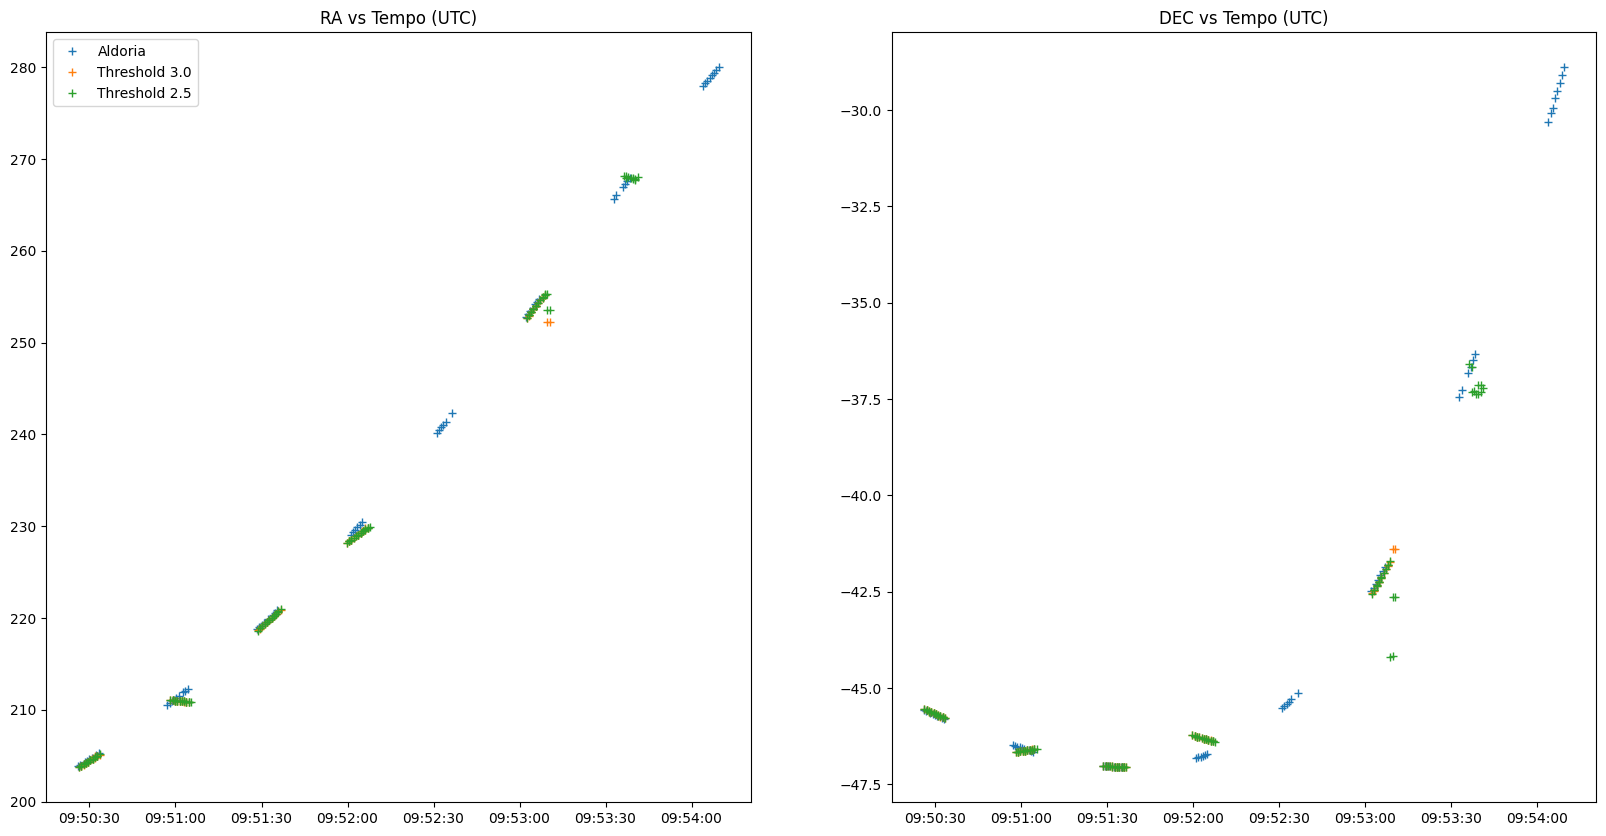

In [5]:
plot_data(
    df_list=[tdm_aldoria, tdm_30, tdm_25],
    legend=["Aldoria", "Threshold 3.0", "Threshold 2.5"],
    y_data=["RA[deg]", "DEC[deg]"],
)

### Análise de Outliers

Para analisarmos os outliers, devemos interpolar polinomialmente os dados:

In [6]:
# Interpolação inicial dos dados brutos:
_, _, tdm_30_fit_raw = fit_radec_tdm_data(tdm_30, 3)
_, _, tdm_25_fit_raw = fit_radec_tdm_data(tdm_25, 3)

# Filtragem dos dados com base na interpolação inicial de um polinômio de grau 3:
tdm_30_filtered = filter_raw_data(df_raw=tdm_30,df_fit=tdm_30_fit_raw)
tdm_25_filtered = filter_raw_data(df_raw=tdm_25,df_fit=tdm_25_fit_raw)

# Interpolação com os dados fltrados:
poly_ra_30, poly_dec_30, tdm_30_fit = fit_radec_tdm_data(tdm_30_filtered, 3)
poly_ra_25, poly_dec_25, tdm_25_fit = fit_radec_tdm_data(tdm_25_filtered, 3)

### Comparação com os dados da Aldoria

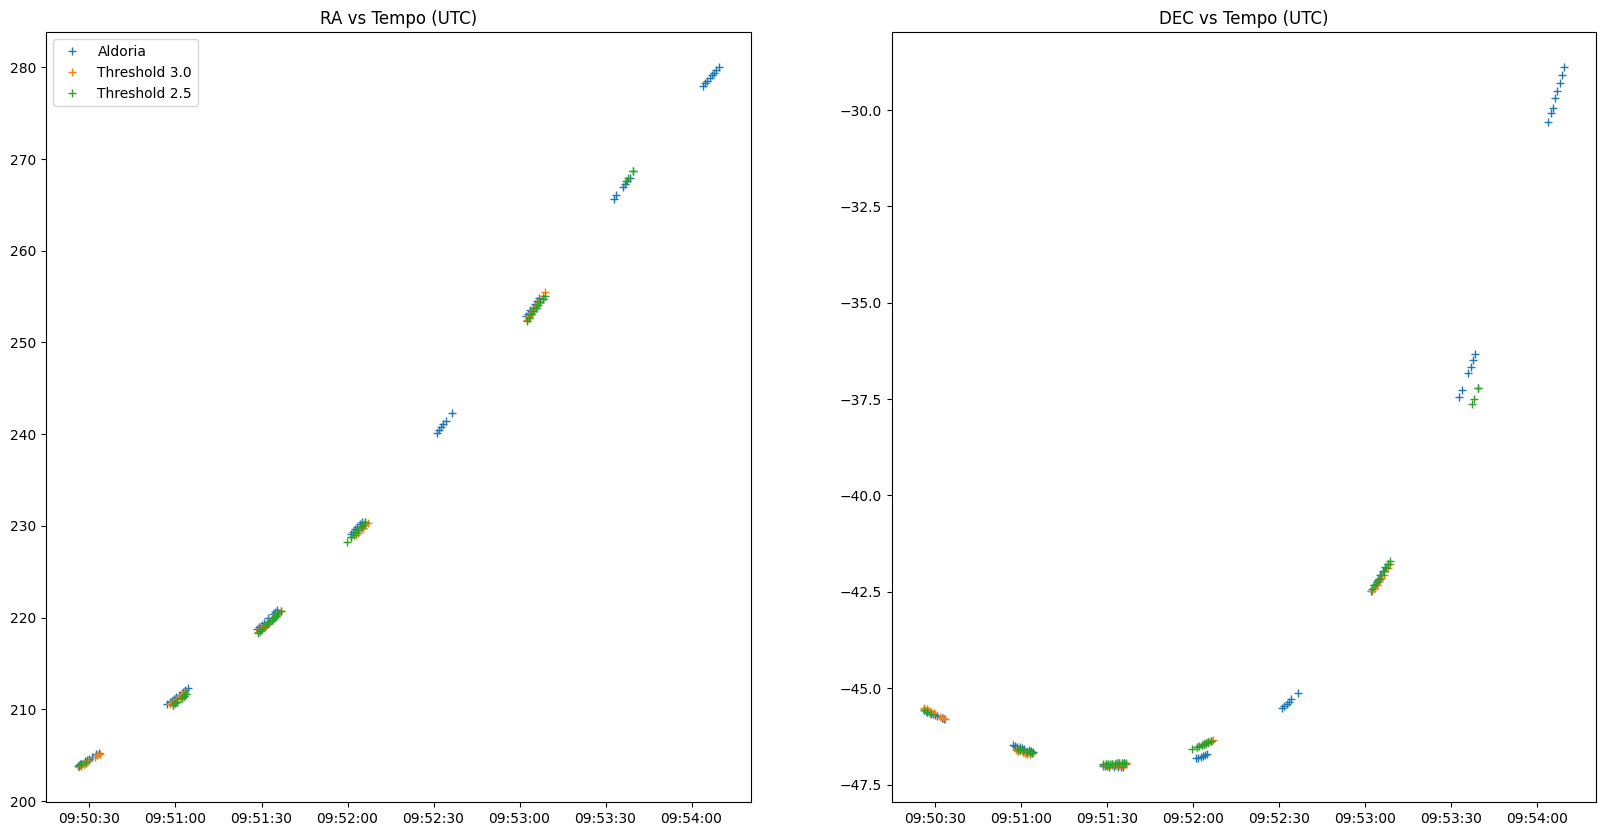

In [7]:
plot_data(df_list=[tdm_aldoria,tdm_30_fit,tdm_25_fit],legend=['Aldoria','Threshold 3.0', 'Threshold 2.5'],y_data=['RA[deg]','DEC[deg]'])

In [8]:
# Comparaçã com os dados interpolados com os valores do TDM da Aldoria
stats_30 = compare_radec_data(poly_ra_30,poly_dec_30,tdm_aldoria,x_max=tdm_30_filtered['Tempo[s]'].max())
stats_25 = compare_radec_data(poly_ra_25,poly_dec_25,tdm_aldoria,x_max=tdm_25_filtered['Tempo[s]'].max())

# Concatenação dos resultados:
stats = pd.concat([stats_30,stats_25],ignore_index=True)
stats.index = ['Threshold 3.0', 'Threshold 2.5']
stats.head()

,Média RA (%),Média DEC (%),Mediana RA (%),Mediana DEC (%),Desvio Padrão RA (%),Desvio Padrão DEC (%),Máximo erro RA (%),Máximo erro RA (deg),Máximo erro DEC (%),Máximo erro DEC (deg)
Threshold 3.0,0.202757,0.303632,0.166047,0.206644,0.107195,0.279165,0.403167,0.973204,0.853755,0.388588
Threshold 2.5,0.177828,0.562648,0.212851,0.143368,0.083024,0.840177,0.273256,0.592115,3.000995,1.090071


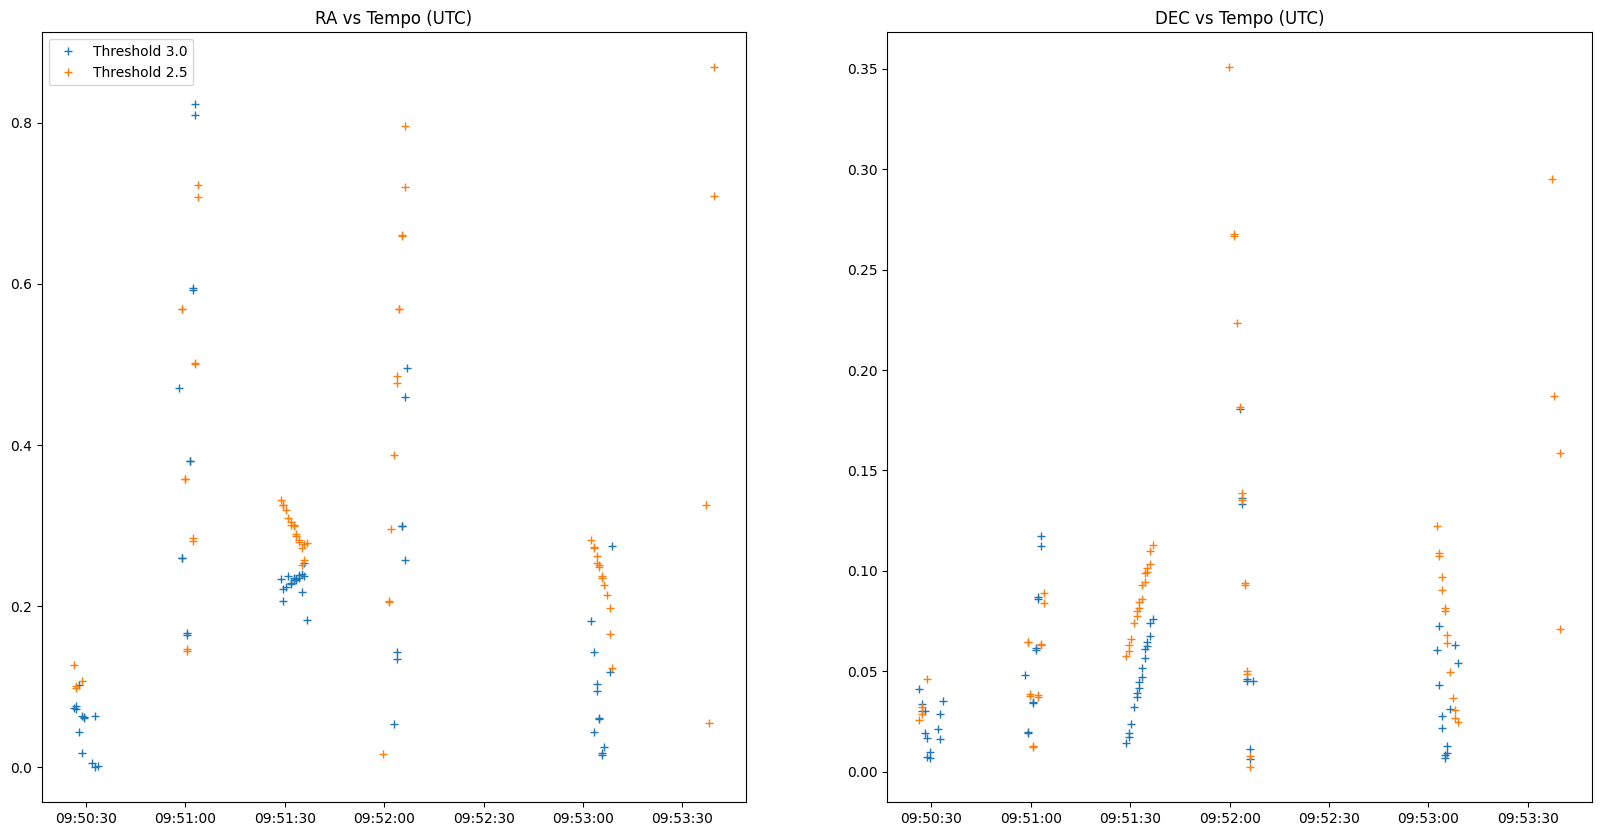

In [9]:
plot_data(df_list=[tdm_30_fit,tdm_25_fit],legend=['Threshold 3.0', 'Threshold 2.5'],y_data=['Desvio RA (deg)','Desvio DEC (deg)'])

In [10]:
from src.models.observatory import Observatory
from src.models.observation import Observation

from src.orbit.orbit_determination import *

from src.tracking_data_message.tracking_data_message import read_tdm



class TLE:
    def __init__(
        self, a: float, i: float, ra: float, e: float, w: float, theta: float
    ) -> None:
        self.a = a
        self.i = i
        self.ra = ra
        self.e = e

        self.w = w

        self.theta = theta



def get_observations(tdm: pd.DataFrame, observatory: Observatory, last_position: int):
    # Posições Analisadas:
    initial = 0
    middle = int(last_position / 2)
    end = last_position - 1

    observations = []

    for i in [initial, middle, end]:
        ra = tdm["RA[deg]"].iloc[i]
        dec = tdm["DEC[deg]"].iloc[i]
        time_utc = tdm["Tempo (UTC)"].iloc[i]
        obs = Observation(ra, dec, time_utc)
        obs.observatory = observatory
        observations.append(obs)
    return observations


def get_iod_state_vector(
    observations: list[Observation], observatory: Observatory
) -> tuple[Vector, Vector]:
    # Posições Analisadas:
    RAs = [observations[0].ra, observations[1].ra, observations[2].ra]
    DECs = [observations[0].dec, observations[1].dec, observations[2].dec]
    local_sidereal_time = [
        observations[0].sidereal_time,
        observations[1].sidereal_time,
        observations[2].sidereal_time,
    ]
    t = [
        observations[0].time_seconds,
        observations[1].time_seconds,
        observations[2].time_seconds,
    ]
    # Estimativa inicial do vetor de estado do objeto (r2,v2):
    r2, v2 = r2v2_from_angles_only_gauss(
        latitude_geodetic=observatory.latitude_geodetic,
        altitude=observatory.altitude,
        local_sidereal_times=local_sidereal_time,
        RAs=RAs,
        DECs=DECs,
        times=t,
    )
    return (r2, v2)



def get_iod_orbital_parameters(r: Vector, v: Vector) -> TLE:

    # Obtenção dos elementos orbitais:
    h, i, ra, e, w, theta = classic_orbital_elements_from_rv(r, v)

    # Obtenção do semi-eixo maior:
    a = semimajor_axis_from_he(h, e)

    return TLE(a, i, ra, e, w, theta)

In [23]:
from src.orbit.orbit_determination import *

# Dados do Observatório da Aldoria:
latitude = -30.5262693  # Latitude geocêntrica do observatório [deg]
longitude = -70.8531799  # [deg]
altitude = 2180e-3  # [km]

observatory_aldoria = Observatory(
    longitude=longitude, latitude=latitude, altitude=altitude
)

# Observações:
tdm_aldoria_raw = read_tdm(filename="Dados\\TDM_7646.txt")
tdm_saipher_30_raw = read_tdm(filename="Dados\\TDM\\Threshold\\TDM-Saipher-30.txt")
tdm_saipher_25_raw = read_tdm(filename="Dados\\TDM\\Threshold\\TDM-Saipher-25.txt")

# Ajuste dos dados:
tdm_saipher_30 = filter_raw_data(df_raw=tdm_saipher_30_raw)
tdm_saipher_25 = filter_raw_data(df_raw=tdm_saipher_25_raw)

# Posições Analisadas:
observations_aldoria = get_observations(
    tdm_aldoria_raw, observatory_aldoria, len(tdm_aldoria_raw["Tempo[s]"])
)
observations_saipher_30 = get_observations(
    tdm_saipher_30, observatory_aldoria, len(tdm_saipher_30["Tempo[s]"])
)
observations_saipher_25 = get_observations(
    tdm_saipher_25, observatory_aldoria, len(tdm_saipher_25["Tempo[s]"])-5
)

# Determinação do Vetor de Estado Inicial da Órbita:
r2_aldoria, v2_aldoria = get_iod_state_vector(
    observations=observations_aldoria, observatory=observatory_aldoria
)
r2_saipher_30, v2_saipher_30 = get_iod_state_vector(
    observations=observations_saipher_30, observatory=observatory_aldoria
)
r2_saipher_25, v2_saipher_25 = get_iod_state_vector(
    observations=observations_saipher_25, observatory=observatory_aldoria
)

# Parâmetros de Órbita:
tle_aldoria = get_iod_orbital_parameters(r2_aldoria, v2_aldoria)
tle_saipher_30 = get_iod_orbital_parameters(r2_saipher_30, v2_saipher_30)
tle_saipher_25 = get_iod_orbital_parameters(r2_saipher_25, v2_saipher_25)

# Dados do TLE
# 1 07646U 75010A   23115.56559076 -.00000125  00000-0  12485-4 0  9994
# 2 07646  49.8253 318.3095 0205748 228.5962 129.7086 13.82317979435651
e_tle = 0.02057480
i_tle = 49.8253
ra_tle = 318.3095
w_tle = 228.5962
a_tle = 7333.814
m_tle = 129.7086


# Resultados:
results = {
    "Aldoria": [
        tle_aldoria.a,
        tle_aldoria.i,
        tle_aldoria.ra,
        tle_aldoria.e,
        tle_aldoria.w,
    ],
    "Saipher - 3.0": [
        tle_saipher_30.a,
        tle_saipher_30.i,
        tle_saipher_30.ra,
        tle_saipher_30.e,
        tle_saipher_30.w,
    ],
    "Saipher - 2.5": [
        tle_saipher_25.a,
        tle_saipher_25.i,
        tle_saipher_25.ra,
        tle_saipher_25.e,
        tle_saipher_25.w,
    ],
    "TLE": [a_tle, i_tle, ra_tle, e_tle, w_tle],
}

orbital_parameters_df = pd.DataFrame(
    index=[
        "Semi-eixo maior [km]",
        "Inclinação [°]",
        "Ascensão reta do nó de ascensão [°]",
        "Ecentricidade [-]",
        "Argumento do Pergieu [°]",
    ],
    data=results,
)

print("Vetores de Estado:")
print(
    f"v2_aldoria = {round(v2_aldoria.x,4)}I + ({round(v2_aldoria.y,4)})J + ({round(v2_aldoria.z,4)})K"
)
print(
    f"v2_saipher = {round(v2_saipher_30.x,4)}I + ({round(v2_saipher_30.y,4)})J + ({round(v2_saipher_30.z,4)})K     (ex = {round(abs(100*(v2_saipher_30.x-v2_aldoria.x)/v2_aldoria.x),4)}% ey = {round(abs(100*(v2_saipher_30.y-v2_aldoria.y)/v2_aldoria.y),4)}% ez = {round(abs(100*(v2_saipher_30.z-v2_aldoria.z)/v2_aldoria.z),4)}%)"
)
print(
    f"v2_saipher = {round(v2_saipher_25.x,4)}I + ({round(v2_saipher_25.y,4)})J + ({round(v2_saipher_25.z,4)})K     (ex = {round(abs(100*(v2_saipher_25.x-v2_aldoria.x)/v2_aldoria.x),4)}% ey = {round(abs(100*(v2_saipher_25.y-v2_aldoria.y)/v2_aldoria.y),4)}% ez = {round(abs(100*(v2_saipher_25.z-v2_aldoria.z)/v2_aldoria.z),4)}%)"
)
print(
    f"r2_aldoria = {round(r2_aldoria.x,4)}I + ({round(r2_aldoria.y,4)})J + ({round(r2_aldoria.z,4)})K"
)
print(
    f"r2_saipher = {round(r2_saipher_30.x,4)}I + ({round(r2_saipher_30.y,4)})J + ({round(r2_saipher_30.z,4)})K     (ex = {round(abs(100*(r2_saipher_30.x-r2_aldoria.x)/r2_aldoria.x),4)}% ey = {round(abs(100*(r2_saipher_30.y-r2_aldoria.y)/r2_aldoria.y),4)}% ez = {round(abs(100*(r2_saipher_30.z-r2_aldoria.z)/r2_aldoria.z),4)}%)"
)
print(
    f"r2_saipher = {round(r2_saipher_25.x,4)}I + ({round(r2_saipher_25.y,4)})J + ({round(r2_saipher_25.z,4)})K     (ex = {round(abs(100*(r2_saipher_25.x-r2_aldoria.x)/r2_aldoria.x),4)}% ey = {round(abs(100*(r2_saipher_25.y-r2_aldoria.y)/r2_aldoria.y),4)}% ez = {round(abs(100*(r2_saipher_25.z-r2_aldoria.z)/r2_aldoria.z),4)}%)"
)
print("\nParâmetros Orbitais:")
orbital_parameters_df

Vetores de Estado:
v2_aldoria = 6.2854I + (-1.3977)J + (3.6609)K
v2_saipher = 6.442I + (-1.657)J + (3.5683)K     (ex = 2.4924% ey = 18.5556% ez = 2.5283%)
v2_saipher = 6.3134I + (-1.5711)J + (3.5257)K     (ex = 0.4454% ey = 12.4059% ez = 3.6926%)
r2_aldoria = 1334.598I + (-5861.4097)J + (-4166.6119)K
r2_saipher = 1111.9638I + (-5829.2508)J + (-4309.311)K     (ex = 16.6817% ey = 0.5487% ez = 3.4248%)
r2_saipher = 1147.8277I + (-5815.6308)J + (-4272.151)K     (ex = 13.9945% ey = 0.781% ez = 2.533%)

Parâmetros Orbitais:


,Aldoria,Saipher - 3.0,Saipher - 2.5,TLE
Semi-eixo maior [km],7363.593056,7706.711605,7334.628766,7333.814000
Inclinação [°],49.774642,49.814238,49.767195,49.825300
Ascensão reta do nó de ascensão [°],318.718731,318.631585,318.735792,318.309500
Ecentricidade [-],0.025400,0.054952,0.024725,0.020575
Argumento do Pergieu [°],235.640729,279.857765,227.418962,228.596200


In [25]:
# Parâmetros Orbitais para a Saipher

# # Dados do Observatório da Aldoria:
# latitude = -30.5262693                                          # Latitude geocêntrica do observatório [deg]
# longitude = -70.8531799                                         # [deg]
# altitude = 2180e-3                                              # [km]
# latitude_geodetic = np.rad2deg(get_geodetic_latitude(latitude)) # Latitude geodética do observatório [deg]

# Dados do Observatório da Aldoria:
latitude = -30.5262693  # Latitude geocêntrica do observatório [deg]
longitude = -70.8531799  # [deg]
altitude = 2180e-3  # [km]

observatory_aldoria = Observatory(
    longitude=longitude, latitude=latitude, altitude=altitude
)

# Observações:
tdm_aldoria_raw = read_tdm(filename="Dados\\TDM_7646.txt")
tdm_saipher_30_raw = read_tdm(filename="Dados\\TDM\\Threshold\\TDM-Saipher-30.txt")
tdm_saipher_25_raw = read_tdm(filename="Dados\\TDM\\Threshold\\TDM-Saipher-25.txt")

# Ajuste dos dados:
tdm_aldoria = filter_raw_data(df_raw=tdm_aldoria_raw)
tdm_saipher_30 = filter_raw_data(df_raw=tdm_saipher_30_raw)
tdm_saipher_25 = filter_raw_data(df_raw=tdm_saipher_25_raw)

# Inicialização dos dados:
tles_aldoria = []
tles_saipher_30 = []
tles_saipher_25 = []

# Populando os TLEs:
for i in range(2, len(tdm_aldoria_raw["Tempo[s]"])):
    obs = get_observations(tdm_aldoria_raw, observatory_aldoria, i)
    r, v = get_iod_state_vector(observations=obs, observatory=observatory_aldoria)
    tle = get_iod_orbital_parameters(r, v)
    tles_aldoria.append(tle)

df_aldoria = pd.DataFrame(data=tles_aldoria)
df_aldoria.head()

# # Posições Analisadas:
# observations_aldoria = get_observations(
#     tdm_aldoria_raw, observatory_aldoria, len(tdm_aldoria_raw["Tempo[s]"])
# )
# observations_saipher_30 = get_observations(
#     tdm_saipher_30, observatory_aldoria, len(tdm_saipher_30["Tempo[s]"])
# )
# observations_saipher_25 = get_observations(
#     tdm_saipher_25, observatory_aldoria, len(tdm_saipher_25["Tempo[s]"]) - 5
# )

# # Determinação do Vetor de Estado Inicial da Órbita:
# r2_aldoria, v2_aldoria = get_iod_state_vector(
#     observations=observations_aldoria, observatory=observatory_aldoria
# )
# r2_saipher_30, v2_saipher_30 = get_iod_state_vector(
#     observations=observations_saipher_30, observatory=observatory_aldoria
# )
# r2_saipher_25, v2_saipher_25 = get_iod_state_vector(
#     observations=observations_saipher_25, observatory=observatory_aldoria
# )

# # Parâmetros de Órbita:
# tle_aldoria = get_iod_orbital_parameters(r2_aldoria, v2_aldoria)
# tle_saipher_30 = get_iod_orbital_parameters(r2_saipher_30, v2_saipher_30)
# tle_saipher_25 = get_iod_orbital_parameters(r2_saipher_25, v2_saipher_25)


# # Observações:
# tdm_saipher_bruto = tdm_30_filtered

# # Ajuste dos dados
# # tdm_saipher = radec_fit(original_data=tdm_saipher_bruto,poly_degree=3,t_start=tdm_saipher_bruto['Tempo[s]'].min(),t_end=tdm_saipher_bruto['Tempo[s]'].max()+60)
# tdm_saipher = tdm_saipher_bruto

# n_saipher = len(tdm_saipher["Tempo[s]"])  # Quantidade de observações realizadas

# # Parâmetros:
# dt_saipher = []
# a_saipher = []
# i_saipher = []
# omega_saipher = []
# w_saipher = []
# e_saipher = []

# for n in range(2, n_saipher):
#     # Posições Analisadas:
#     initial_saipher = 0
#     middle_saipher = int(n / 2)
#     end_saipher = n

#     # Parâmetros únicos de cada "TDM":
#     t_saipher = [
#         tdm_saipher["Tempo[s]"].iloc[initial_saipher],
#         tdm_saipher["Tempo[s]"].iloc[middle_saipher],
#         tdm_saipher["Tempo[s]"].iloc[end_saipher],
#     ]  # Horário das observações utilizadas na IOD [s]
#     local_sidereal_time_saipher = [
#         sidereal_time(
#             longitude=longitude, date=tdm_saipher["Tempo (UTC)"].iloc[initial_saipher]
#         ),
#         sidereal_time(
#             longitude=longitude, date=tdm_saipher["Tempo (UTC)"].iloc[middle_saipher]
#         ),
#         sidereal_time(
#             longitude=longitude, date=tdm_saipher["Tempo (UTC)"].iloc[end_saipher]
#         ),
#     ]
#     RAs_saipher = [
#         tdm_saipher["RA[deg]"].iloc[initial_saipher],
#         tdm_saipher["RA[deg]"].iloc[middle_saipher],
#         tdm_saipher["RA[deg]"].iloc[end_saipher],
#     ]
#     DECs_saipher = [
#         tdm_saipher["DEC[deg]"].iloc[initial_saipher],
#         tdm_saipher["DEC[deg]"].iloc[middle_saipher],
#         tdm_saipher["DEC[deg]"].iloc[end_saipher],
#     ]

#     # Estimativa inicial do vetor de estado do objeto (r2,v2):
#     r2, v2 = r2v2_from_angles_only_gauss(
#         latitude_geodetic=latitude_geodetic,
#         altitude=altitude,
#         local_sidereal_times=local_sidereal_time_saipher,
#         RAs=RAs_saipher,
#         DECs=DECs_saipher,
#         times=t_saipher,
#     )

#     # Parâmetros Orbitais:
#     h, i, omega, e, w, theta = classic_orbital_elements_from_rv(r2, v2)
#     a = semimajor_axis_from_he(h, e)

#     # Adição dos Dados Obtidos:
#     dt_saipher.append(t_saipher[2] - t_saipher[0])
#     a_saipher.append(a)
#     i_saipher.append(i)
#     omega_saipher.append(omega)
#     w_saipher.append(w)
#     e_saipher.append(e)

# # Criação de Data Frame com os Dados:
# orbital_param_saipher = pd.DataFrame(
#     data={
#         "Delta_t": dt_saipher,
#         "a": a_saipher,
#         "i": i_saipher,
#         "omega": omega_saipher,
#         "w": w_saipher,
#         "e": e_saipher,
#     }
# )

# # Filtro de Outliers:
# orbital_param_saipher.dropna(inplace=True)
# orbital_param_saipher.where((orbital_param_saipher["e"] < 0.5), inplace=True)

# # Plot dos Resultados:
# plt.figure(figsize=(10, 20))
# # plt.rcParams['text.usetex'] = True
# ax1 = plt.subplot(5, 1, 1)
# ax1.scatter(orbital_param_saipher["Delta_t"], orbital_param_saipher["a"])
# ax1.set_ylabel("$a$ [km]")
# ax1.set_title("Parâmetros Orbitais em Função do Tempo - Saipher")
# ax2 = plt.subplot(5, 1, 2)
# ax2.scatter(orbital_param_saipher["Delta_t"], orbital_param_saipher["e"])
# ax2.set_ylabel("$e$ [-]")
# ax3 = plt.subplot(5, 1, 3)
# ax3.scatter(orbital_param_saipher["Delta_t"], orbital_param_saipher["i"])
# ax3.set_ylabel("$i$ [°]")
# ax4 = plt.subplot(5, 1, 4)
# ax4.scatter(orbital_param_saipher["Delta_t"], orbital_param_saipher["omega"])
# ax4.set_ylabel("$\\Omega$ [°]")
# ax5 = plt.subplot(5, 1, 5)
# ax5.scatter(orbital_param_saipher["Delta_t"], orbital_param_saipher["w"])
# ax5.set_ylabel("$\\omega$ [°]")
# ax5.set_xlabel("$t_3 - t_1$ [s]")
# plt.show()

In [14]:
orbital_param_saipher.describe()
df_saipher = orbital_param_saipher[orbital_param_saipher.e < orbital_param_saipher.describe().e['25%']]
df_saipher.describe()

,Delta_t,a,i,omega,w,e
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,159.613837,7353.449117,49.780898,318.709667,229.747322,0.034202
std,2.572792,208.130054,0.018228,0.043111,47.802732,0.001790
min,157.746333,7113.740904,49.760669,318.675939,174.741450,0.032692
25%,158.146514,7286.053822,49.773323,318.685381,214.004203,0.033213
50%,158.546694,7458.366741,49.785978,318.694823,253.266956,0.033734
75%,160.547589,7473.303224,49.791013,318.726531,257.250259,0.034957
max,162.548483,7488.239708,49.796048,318.758239,261.233561,0.036180


## Análise de FOV Parameter

Nessa análise, alterou-se o parâmetro multiplicador do FOV para 1.5 e a área de procura de estrelas no Gaia passou a ser retangular.

In [15]:
tdm_aldoria = get_track_data('Dados\\TDM_7646.txt')
tdm_30 = get_track_data('Dados\\TDM\\Field-Of-View\\TDM-Saipher-15.txt')
tdm_25 = get_track_data('Dados\\TDM\\Field-Of-View\\TDM-Saipher-15-25.txt')


NameError: name 'get_track_data' is not defined

C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_15036\2665463845.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_aldoria['Tempo (UTC)'],tdm_aldoria['RA[deg]'],'r+',color='blue')
C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_15036\2665463845.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_30['Tempo (UTC)'],tdm_30['RA[deg]'],'r+',color='red')
C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_15036\2665463845.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_25['Tempo (UTC)'],tdm_25['RA[deg]'],'r+',color='green')
C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_15036\2665463845.py:12: User

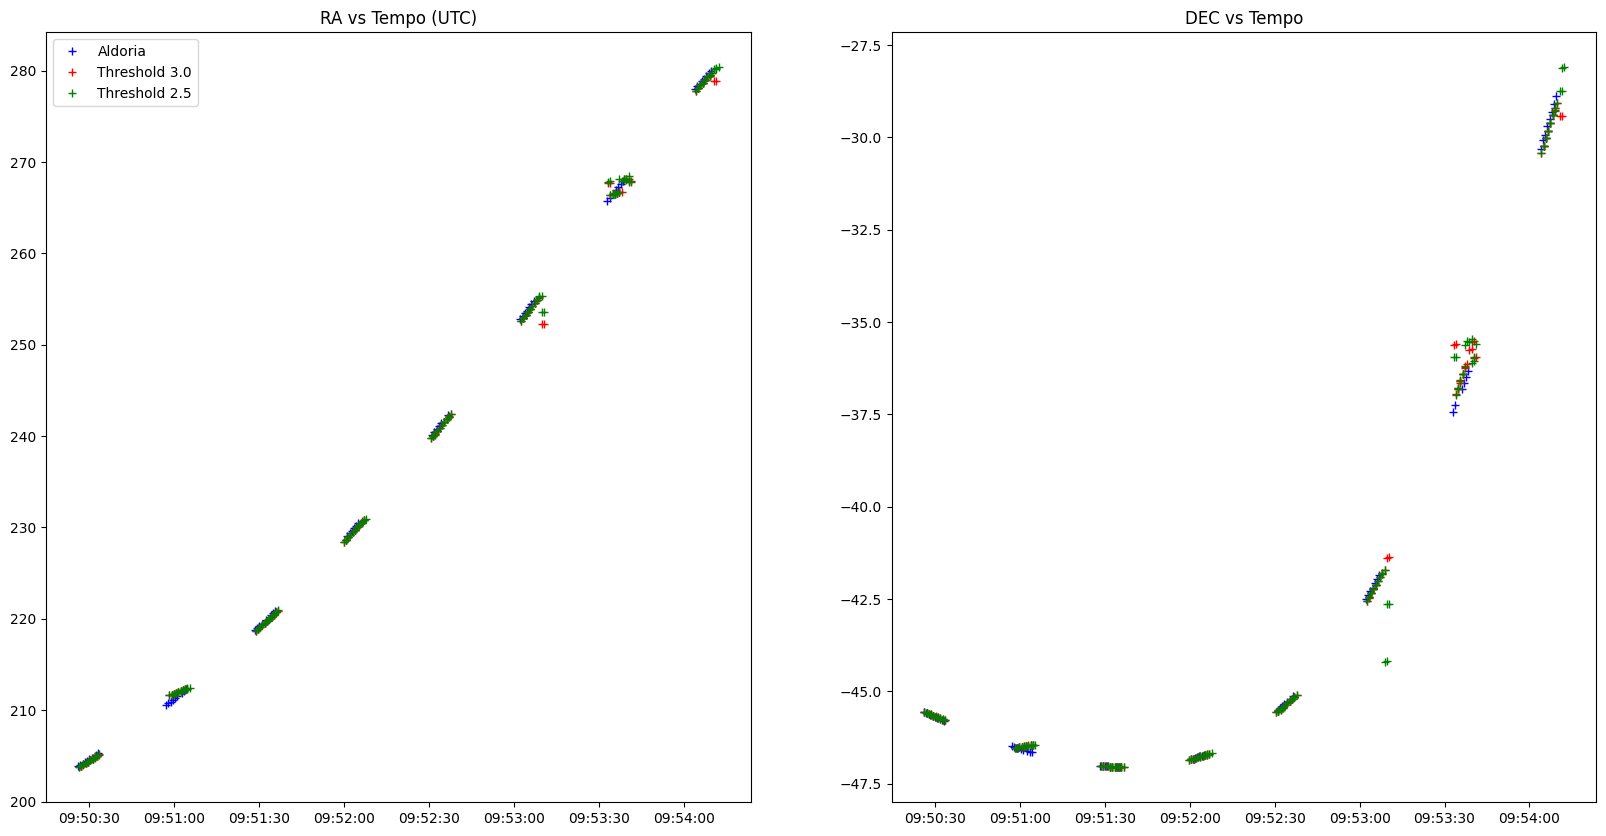

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(tdm_aldoria['Tempo (UTC)'],tdm_aldoria['RA[deg]'],'r+',color='blue')
plt.plot(tdm_30['Tempo (UTC)'],tdm_30['RA[deg]'],'r+',color='red')
plt.plot(tdm_25['Tempo (UTC)'],tdm_25['RA[deg]'],'r+',color='green')
plt.legend(['Aldoria','Threshold 3.0', 'Threshold 2.5'])
plt.title('RA vs Tempo (UTC)')

plt.subplot(1,2,2)
plt.plot(tdm_aldoria['Tempo (UTC)'],tdm_aldoria['DEC[deg]'],'r+',color='blue')
plt.plot(tdm_30['Tempo (UTC)'],tdm_30['DEC[deg]'],'r+',color='red')
plt.plot(tdm_25['Tempo (UTC)'],tdm_25['DEC[deg]'],'r+',color='green')
plt.title('DEC vs Tempo')
plt.show()

### Tratamento de Outliers

In [ ]:
# Interpolação dos dados de 3.0 Threshold:
tdm_30_fit = interpolar_dados(tdm_30,tdm_30)
tdm_30_filtered = tdm_30

# Interpolação dos dados de 2.5 Threshold:
tdm_25_fit = interpolar_dados(tdm_25,tdm_25)
tdm_25_filtered = tdm_25

In [ ]:
# Filtragem a partir do RA
std_ra = tdm_30_fit.describe().loc['std','Desvio RA (%)']
mean_ra = tdm_30_fit.describe().loc['mean','Desvio RA (%)']
third_quarter_ra = tdm_30_fit.describe().loc['75%','Desvio RA (%)']
std_dec = tdm_30_fit.describe().loc['std','Desvio DEC (%)']
mean_dec = tdm_30_fit.describe().loc['mean','Desvio DEC (%)']
third_quarter_dec = tdm_30_fit.describe().loc['75%','Desvio DEC (%)']
# filter = (abs(tdm_30_fit['Desvio RA (%)'] - mean_ra) < 0.5*std_ra) & (abs(tdm_30_fit['Desvio DEC (%)'] - mean_dec) < 0.5*std_dec)
# filter = (tdm_30_fit['Desvio RA (%)'] < third_quarter_ra) & (tdm_30_fit['Desvio DEC (%)'] < third_quarter_dec)
filter = (tdm_30_fit['Desvio RA (deg)'] < 0.25) & (tdm_30_fit['Desvio DEC (deg)'] < 0.25)
time_filtered = tdm_30_fit[filter]['Tempo[s]']
tdm_30_filtered = tdm_30.loc[tdm_30['Tempo[s]'].isin(time_filtered)]

In [ ]:
# Filtragem a partir do RA
std_ra = tdm_25_fit.describe().loc['std','Desvio RA (%)']
mean_ra = tdm_25_fit.describe().loc['mean','Desvio RA (%)']
third_quarter_ra = tdm_25_fit.describe().loc['75%','Desvio RA (%)']
std_dec = tdm_25_fit.describe().loc['std','Desvio DEC (%)']
mean_dec = tdm_25_fit.describe().loc['mean','Desvio DEC (%)']
third_quarter_dec = tdm_25_fit.describe().loc['75%','Desvio DEC (%)']
# filter = (abs(tdm_25_fit['Desvio RA (%)'] - mean_ra) < 0.5*std_ra) & (abs(tdm_25_fit['Desvio DEC (%)'] - mean_dec) < 0.5*std_dec)
# filter = (tdm_25_fit['Desvio RA (%)'] < third_quarter_ra) & (tdm_25_fit['Desvio DEC (%)'] < third_quarter_dec)
filter = (tdm_25_fit['Desvio RA (deg)'] < 0.25) & (tdm_25_fit['Desvio DEC (deg)'] < 0.25)
time_filtered = tdm_25_fit[filter]['Tempo[s]']
tdm_25_filtered = tdm_25.loc[tdm_25['Tempo[s]'].isin(time_filtered)]

C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_15036\3058185789.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_aldoria['Tempo (UTC)'],tdm_aldoria['RA[deg]'],'r+',color='blue')
C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_15036\3058185789.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_30_filtered['Tempo (UTC)'],tdm_30_filtered['RA[deg]'],'r+',color='red')
C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_15036\3058185789.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_25_filtered['Tempo (UTC)'],tdm_25_filtered['RA[deg]'],'r+',color='green')
C:\Users\rafael.facchin\AppData\Local\Temp\ip

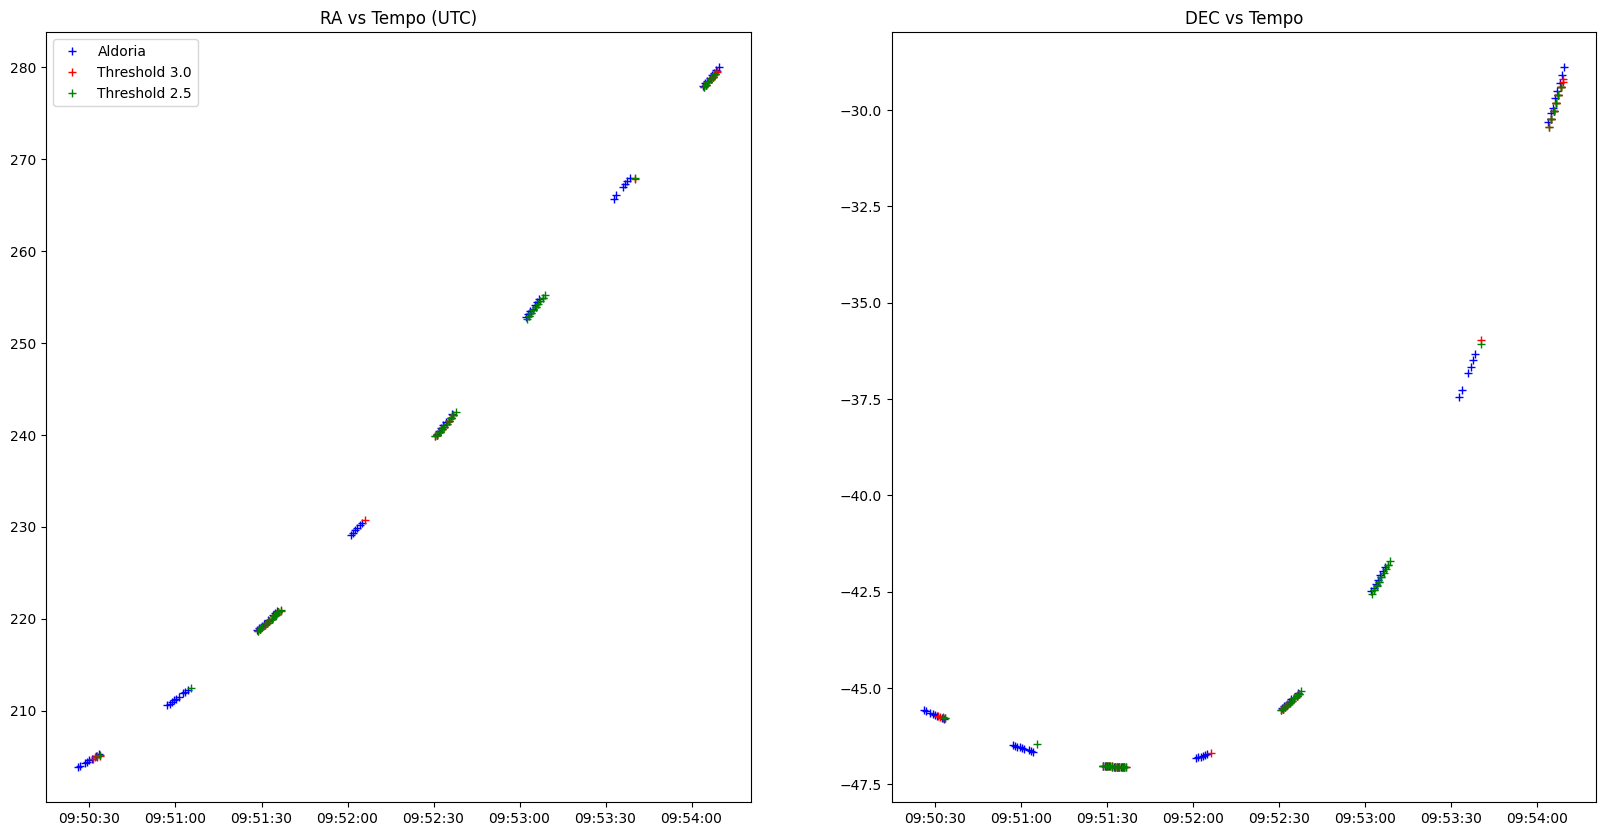

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(tdm_aldoria['Tempo (UTC)'],tdm_aldoria['RA[deg]'],'r+',color='blue')
plt.plot(tdm_30_filtered['Tempo (UTC)'],tdm_30_filtered['RA[deg]'],'r+',color='red')
plt.plot(tdm_25_filtered['Tempo (UTC)'],tdm_25_filtered['RA[deg]'],'r+',color='green')
plt.legend(['Aldoria','Threshold 3.0', 'Threshold 2.5'])
plt.title('RA vs Tempo (UTC)')

plt.subplot(1,2,2)
plt.plot(tdm_aldoria['Tempo (UTC)'],tdm_aldoria['DEC[deg]'],'r+',color='blue')
plt.plot(tdm_30_filtered['Tempo (UTC)'],tdm_30_filtered['DEC[deg]'],'r+',color='red')
plt.plot(tdm_25_filtered['Tempo (UTC)'],tdm_25_filtered['DEC[deg]'],'r+',color='green')
plt.title('DEC vs Tempo')
plt.show()

In [ ]:
# Interpolação dos dados de 3.0 Threshold:
tdm_30_fit = interpolar_dados(tdm_30_filtered,tdm_aldoria)

# Interpolação dos dados de 2.5 Threshold:
tdm_25_fit = interpolar_dados(tdm_25_filtered,tdm_aldoria)

C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_15036\3207789637.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_aldoria[filter]['Tempo (UTC)'],tdm_aldoria[filter]['RA[deg]'],'r+',color='blue')
C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_15036\3207789637.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['RA[deg]'],'r+',color='red')
C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_15036\3207789637.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['RA[deg]'],'r+',color='green')
C:\Users\rafael.facchin\AppData\Local\Temp\ipyker

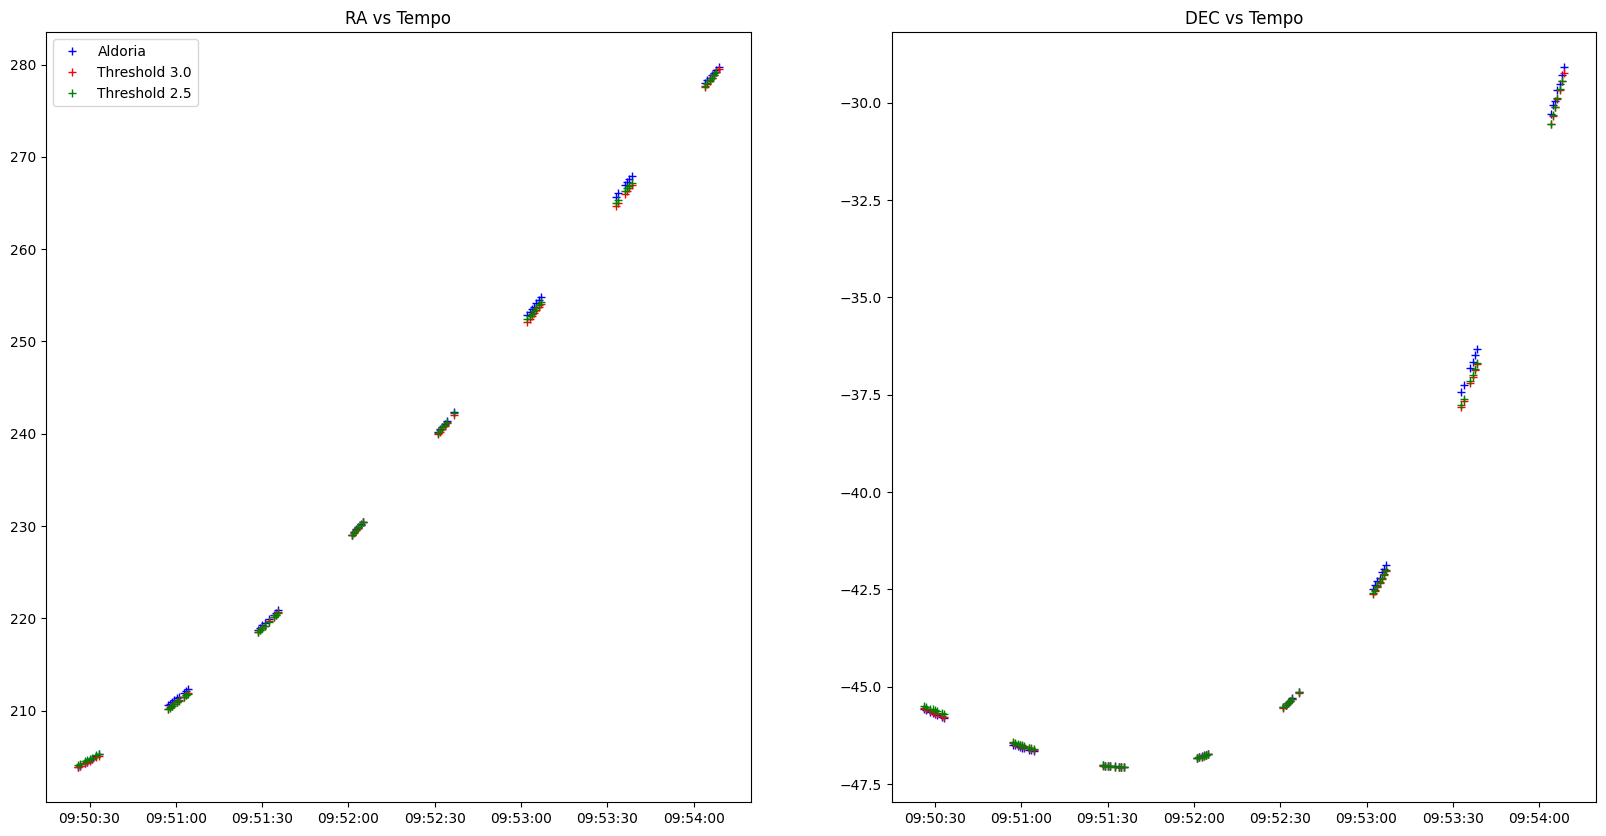

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
t_12_max = (tdm_30_fit['Tempo[s]']).max()
filter = (tdm_aldoria['Tempo[s]'] <= t_12_max)
plt.plot(tdm_aldoria[filter]['Tempo (UTC)'],tdm_aldoria[filter]['RA[deg]'],'r+',color='blue')
plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['RA[deg]'],'r+',color='red')
plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['RA[deg]'],'r+',color='green')
plt.legend(['Aldoria','Threshold 3.0', 'Threshold 2.5'])
plt.title('RA vs Tempo')

plt.subplot(1,2,2)
plt.plot(tdm_aldoria[filter]['Tempo (UTC)'],tdm_aldoria[filter]['DEC[deg]'],'r+',color='blue')
plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['DEC[deg]'],'r+',color='red')
plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['DEC[deg]'],'r+',color='green')
plt.title('DEC vs Tempo')
plt.show()

In [ ]:
import numpy as np

#Desvios para RA
median_ra = np.median(tdm_30_fit['Desvio RA (%)'])
mean_ra = np.mean(tdm_30_fit['Desvio RA (%)'])
std_ra = np.std(tdm_30_fit['Desvio RA (%)'])

#Desvios para DEC
median_dec = np.median(tdm_30_fit['Desvio DEC (%)'])
mean_dec = np.mean(tdm_30_fit['Desvio DEC (%)'])
std_dec = np.std(tdm_30_fit['Desvio DEC (%)'])

dados_stats = {
    'Média RA (%)':mean_ra,
    'Média DEC (%)':mean_dec,
    'Mediana RA (%)':median_ra,
    'Mediana DEC (%)':median_dec,
    'Desvio Padrão RA (%)': std_ra,
    'Desvio Padrão DEC (%)': std_dec,
    'Máximo erro RA (%)': tdm_30_fit['Desvio RA (%)'].max(),
    'Máximo erro RA (deg)': tdm_30_fit['Desvio RA (deg)'].max(),
    'Máximo erro DEC (%)': tdm_30_fit['Desvio DEC (%)'].max(),
    'Máximo erro DEC (deg)': tdm_30_fit['Desvio DEC (deg)'].max()
}

stats = pd.DataFrame(index = ['Threshold 3.0'] ,data = dados_stats)

#Desvios para RA
median_ra = np.median(tdm_25_fit['Desvio RA (%)'])
mean_ra = np.mean(tdm_25_fit['Desvio RA (%)'])
std_ra = np.std(tdm_25_fit['Desvio RA (%)'])

#Desvios para DEC
median_dec = np.median(tdm_25_fit['Desvio DEC (%)'])
mean_dec = np.mean(tdm_25_fit['Desvio DEC (%)'])
std_dec = np.std(tdm_25_fit['Desvio DEC (%)'])

dados_stats = {
    'Média RA (%)':mean_ra,
    'Média DEC (%)':mean_dec,
    'Mediana RA (%)':median_ra,
    'Mediana DEC (%)':median_dec,
    'Desvio Padrão RA (%)': std_ra,
    'Desvio Padrão DEC (%)': std_dec,
    'Máximo erro RA (%)': tdm_25_fit['Desvio RA (%)'].max(),
    'Máximo erro RA (deg)': tdm_25_fit['Desvio RA (deg)'].max(),
    'Máximo erro DEC (%)': tdm_25_fit['Desvio DEC (%)'].max(),
    'Máximo erro DEC (deg)': tdm_25_fit['Desvio DEC (deg)'].max()
}

stats = stats._append(dados_stats,ignore_index=True)
stats.index = ['Threshold 3.0', 'Threshold 2.5']

stats.head()

,Média RA (%),Média DEC (%),Mediana RA (%),Mediana DEC (%),Desvio Padrão RA (%),Desvio Padrão DEC (%),Máximo erro RA (%),Máximo erro RA (deg),Máximo erro DEC (%),Máximo erro DEC (deg)
Threshold 3.0,0.151570,0.265414,0.114593,0.074718,0.107608,0.345488,0.386955,1.029578,1.086627,0.404776
Threshold 2.5,0.128364,0.258114,0.125583,0.135631,0.082811,0.307522,0.293580,0.781133,0.996399,0.371165


C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_15036\1492955811.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['Desvio RA (deg)'],'r+',color='red')
C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_15036\1492955811.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['Desvio RA (deg)'],'r+',color='green')
C:\Users\rafael.facchin\AppData\Local\Temp\ipykernel_15036\1492955811.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['Desvio DEC (deg)'],'r+',color='red')
C:\Users\rafael.facchin\AppData\Local\Temp\

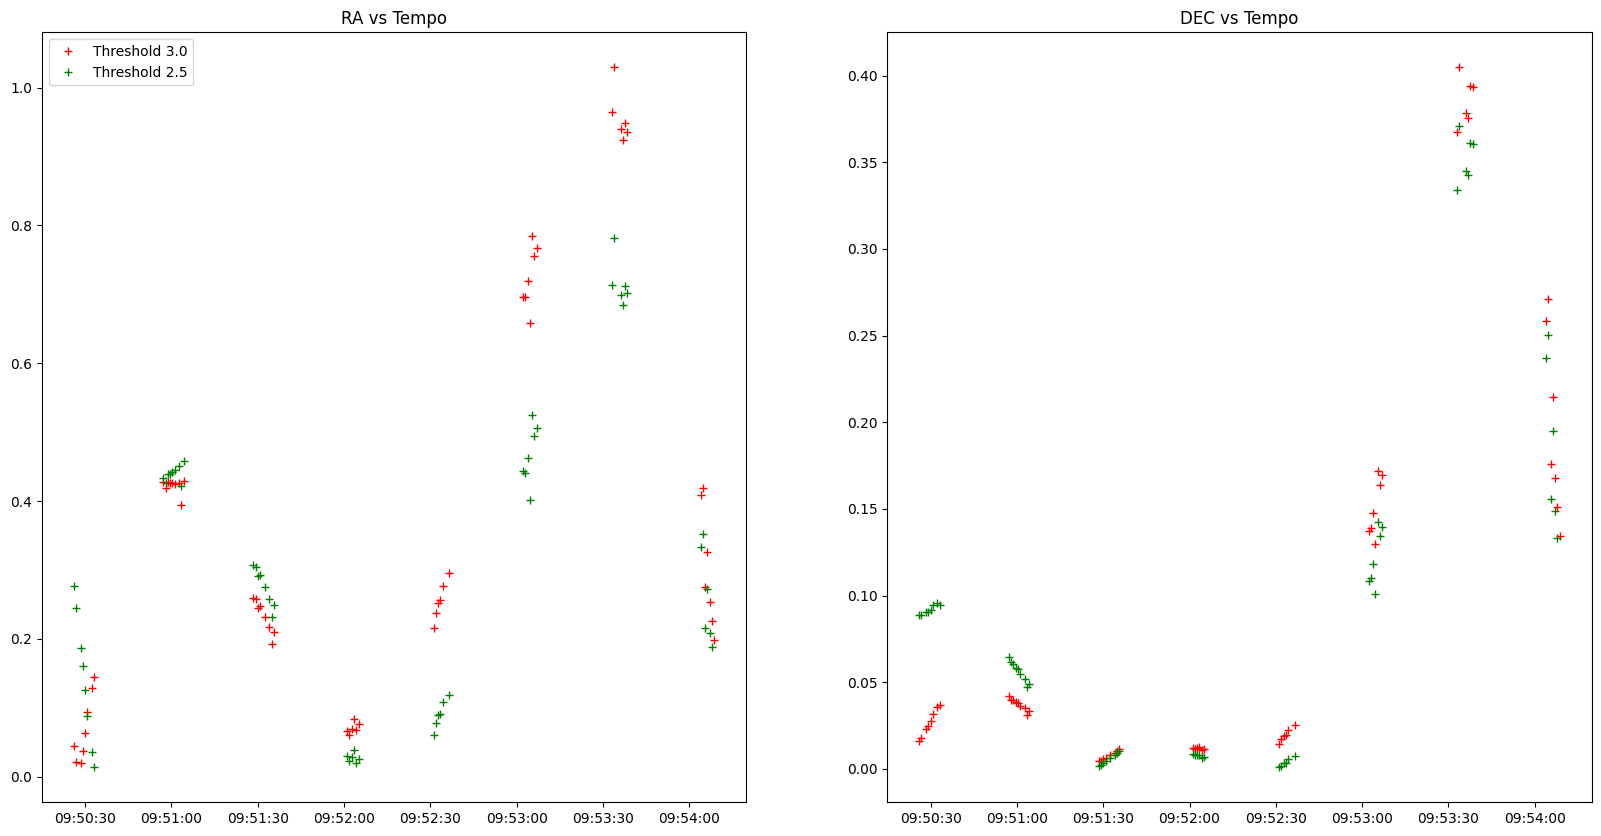

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['Desvio RA (deg)'],'r+',color='red')
plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['Desvio RA (deg)'],'r+',color='green')
plt.legend(['Threshold 3.0', 'Threshold 2.5'])
plt.title('RA vs Tempo')

plt.subplot(1,2,2)
plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['Desvio DEC (deg)'],'r+',color='red')
plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['Desvio DEC (deg)'],'r+',color='green')
plt.title('DEC vs Tempo')
plt.show()

In [ ]:
tdm_25_fit.describe()

,Tempo (UTC),Tempo[s],RA[deg],DEC[deg],Desvio RA (%),Desvio DEC (%),Desvio RA (deg),Desvio DEC (deg)
count,56,5.600000e+01,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,2023-04-25 09:52:09.263169536,1.682427e+09,234.950151,-43.064533,0.128364,0.258114,0.306047,0.097167
min,2023-04-25 09:50:26.038453,1.682427e+09,204.125061,-47.062594,0.006526,0.001957,0.013395,0.000891
25%,2023-04-25 09:51:02.293469440,1.682427e+09,211.356882,-46.630769,0.047894,0.016942,0.115949,0.007926
50%,2023-04-25 09:52:03.056783616,1.682427e+09,229.732697,-45.567374,0.125583,0.135631,0.284026,0.063057
75%,2023-04-25 09:53:05.535154176,1.682427e+09,253.731159,-42.179262,0.203311,0.323074,0.442681,0.133301
max,2023-04-25 09:54:07.873966,1.682427e+09,279.225617,-29.437028,0.293580,0.996399,0.781133,0.371165
std,NaN,7.200131e+01,25.005763,5.457456,0.083561,0.310305,0.210590,0.107946


In [ ]:
tdm_saipher_bruto = tdm_30_fit
tdm_saipher = tdm_saipher_bruto

n_saipher = len(tdm_saipher['Tempo[s]'])                                # Quantidade de observações realizadas

initial_saipher = 0
middle_saipher = int(n_saipher/2)
end_saipher = n_saipher - 1

# t_saipher = [tdm_saipher['Tempo[s]'][initial_saipher],tdm_saipher['Tempo[s]'][middle_saipher],tdm_saipher['Tempo[s]'][end_saipher]] # Horário das observações utilizadas na IOD [s]


In [ ]:
tdm_saipher['Tempo[s]'].iloc[initial_saipher]

1682427026.038453

In [ ]:
from src.orbit.orbit_determination import *

# Dados do Observatório da Aldoria:
latitude = -30.5262693                                          # Latitude geocêntrica do observatório [deg]
longitude = -70.8531799                                         # [deg]
altitude = 2180e-3                                              # [km]
latitude_geodetic = np.rad2deg(get_geodetic_latitude(latitude)) # Latitude geodética do observatório [deg]

# Observações:
tdm_aldoria_bruto = get_track_data('Dados\\TDM_7646.txt')
tdm_saipher_bruto = tdm_25_filtered
# tdm_saipher_bruto = tdm_30_filtered

# Ajuste dos dados
# tdm_saipher = radec_fit(original_data=tdm_saipher_bruto,poly_degree=3,t_start=tdm_saipher_bruto['Tempo[s]'].min(),t_end=tdm_saipher_bruto['Tempo[s]'].max())
tdm_aldoria = tdm_aldoria_bruto[tdm_aldoria_bruto['Tempo[s]'] <= max(tdm_saipher_bruto['Tempo[s]'])]
tdm_saipher = tdm_saipher_bruto

n_aldoria = len(tdm_aldoria['Tempo[s]'])                                # Quantidade de observações realizadas
n_saipher = len(tdm_saipher['Tempo[s]'])                                # Quantidade de observações realizadas

# Posições Analisadas:
initial_aldoria = 0
middle_aldoria = int(n_aldoria/2)
end_aldoria = n_aldoria - 1
initial_saipher = 0
middle_saipher = int(n_saipher/2)
end_saipher = n_saipher - 1

# Parâmetros únicos de cada "TDM":
t_aldoria = [tdm_aldoria['Tempo[s]'][initial_aldoria],tdm_aldoria['Tempo[s]'][middle_aldoria],tdm_aldoria['Tempo[s]'][end_aldoria]] # Horário das observações utilizadas na IOD [s]
t_saipher = [tdm_saipher['Tempo[s]'].iloc[initial_saipher],tdm_saipher['Tempo[s]'].iloc[middle_saipher],tdm_saipher['Tempo[s]'].iloc[end_saipher]] # Horário das observações utilizadas na IOD [s]
local_sidereal_time_aldoria = [
    sidereal_time(longitude=longitude,date=tdm_aldoria['Tempo (UTC)'][initial_aldoria]),
    sidereal_time(longitude=longitude,date=tdm_aldoria['Tempo (UTC)'][middle_aldoria]),
    sidereal_time(longitude=longitude,date=tdm_aldoria['Tempo (UTC)'][end_aldoria]),
    ]
local_sidereal_time_saipher = [
    sidereal_time(longitude=longitude,date=tdm_saipher['Tempo (UTC)'].iloc[initial_saipher]),
    sidereal_time(longitude=longitude,date=tdm_saipher['Tempo (UTC)'].iloc[middle_saipher]),
    sidereal_time(longitude=longitude,date=tdm_saipher['Tempo (UTC)'].iloc[end_saipher]),
    ]
RAs_aldoria = [tdm_aldoria['RA[deg]'][initial_aldoria],tdm_aldoria['RA[deg]'][middle_aldoria],tdm_aldoria['RA[deg]'][end_aldoria]]
DECs_aldoria = [tdm_aldoria['DEC[deg]'][initial_aldoria],tdm_aldoria['DEC[deg]'][middle_aldoria],tdm_aldoria['DEC[deg]'][end_aldoria]]
RAs_saipher = [tdm_saipher['RA[deg]'].iloc[initial_saipher],tdm_saipher['RA[deg]'].iloc[middle_saipher],tdm_saipher['RA[deg]'].iloc[end_saipher]]
# RAs_saipher = [
#     0.5*(tdm_saipher['RA[deg]'][initial_saipher] + RAs_aldoria[0]),
#     0.5*(tdm_saipher['RA[deg]'][middle_saipher] + RAs_aldoria[1]),
#     (1/4)*(tdm_saipher['RA[deg]'][end_saipher] + 3*RAs_aldoria[2])
# ]
DECs_saipher = [tdm_saipher['DEC[deg]'].iloc[initial_saipher],tdm_saipher['DEC[deg]'].iloc[middle_saipher],tdm_saipher['DEC[deg]'].iloc[end_saipher]]

# Estimativa inicial do vetor de estado do objeto (r2,v2):
r2_aldoria,v2_aldoria = r2v2_from_angles_only_gauss(
    latitude_geodetic = latitude_geodetic,
    altitude = altitude,
    local_sidereal_times = local_sidereal_time_aldoria,
    RAs = RAs_aldoria,
    DECs = DECs_aldoria,
    times = t_aldoria)

r2_saipher,v2_saipher = r2v2_from_angles_only_gauss(
    latitude_geodetic = latitude_geodetic,
    altitude = altitude,
    local_sidereal_times = local_sidereal_time_saipher,
    RAs = RAs_saipher,
    DECs = DECs_saipher,
    times = t_saipher)

# Obtenção dos elementos orbitais:
h_aldoria,i_aldoria,ra_aldoria,e_aldoria,w_aldoria,theta_aldoria = classic_orbital_elements_from_rv(r2_aldoria,v2_aldoria)
h_saipher,i_saipher,ra_saipher,e_saipher,w_saipher,theta_saipher = classic_orbital_elements_from_rv(r2_saipher,v2_saipher)

# Obtenção do semi-eixo maior:
a_aldoria = semimajor_axis_from_he(h_aldoria,e_aldoria)
a_saipher = semimajor_axis_from_he(h_saipher,e_saipher)

# Dados do TLE
# 1 07646U 75010A   23115.56559076 -.00000125  00000-0  12485-4 0  9994
# 2 07646  49.8253 318.3095 0205748 228.5962 129.7086 13.82317979435651
e_tle = 0.02057480
i_tle = 49.8253
ra_tle = 318.3095
w_tle = 228.5962
a_tle = 7333.814
m_tle = 129.7086


# Resultados:
print('Parâmetros de Entrada:')
print('--------------------------------- Aldoria ----------------------------------')
print(f'RA = {np.round(RAs_aldoria,3)}')
print(f'DEC = {np.round(DECs_aldoria,3)}')
print(f'Tempo Sideral = {np.round(local_sidereal_time_aldoria,3)}')
print(f'Intervalos de Tempo [s] = {np.round([t_aldoria[0]-t_aldoria[0],t_aldoria[1]-t_aldoria[0],t_aldoria[2]-t_aldoria[0]],2)}')
print()
print('--------------------------------- Saipher ----------------------------------')
print(f'RA = {np.round(RAs_saipher,3)}')
print(f'DEC = {np.round(DECs_saipher,3)}')
print(f'Tempo Sideral = {np.round(local_sidereal_time_saipher,3)}')
print(f'Intervalos de Tempo [s] = {np.round([t_saipher[0]-t_saipher[0],t_saipher[1]-t_saipher[0],t_saipher[2]-t_saipher[0]],2)}')
print()

results = {
    'Aldoria':[a_aldoria,i_aldoria,ra_aldoria,e_aldoria,w_aldoria],
    'Saipher':[a_saipher,i_saipher,ra_saipher,e_saipher,w_saipher],
    'TLE':[a_tle,i_tle,ra_tle,e_tle,w_tle]
}

orbital_parameters_df = pd.DataFrame(
    index = ['Semi-eixo maior [km]','Inclinação [°]','Ascensão reta do nó de ascensão [°]','Ecentricidade [-]','Argumento do Pergieu [°]'],
    data = results)

print('Vetores de Estado:')
print(f'v2_aldoria = {round(v2_aldoria.x,4)}I + ({round(v2_aldoria.y,4)})J + ({round(v2_aldoria.z,4)})K')
print(f'v2_saipher = {round(v2_saipher.x,4)}I + ({round(v2_saipher.y,4)})J + ({round(v2_saipher.z,4)})K     (ex = {round(abs(100*(v2_saipher.x-v2_aldoria.x)/v2_aldoria.x),4)}% ey = {round(abs(100*(v2_saipher.y-v2_aldoria.y)/v2_aldoria.y),4)}% ez = {round(abs(100*(v2_saipher.z-v2_aldoria.z)/v2_aldoria.z),4)}%)')
print(f'r2_aldoria = {round(r2_aldoria.x,4)}I + ({round(r2_aldoria.y,4)})J + ({round(r2_aldoria.z,4)})K')
print(f'r2_saipher = {round(r2_saipher.x,4)}I + ({round(r2_saipher.y,4)})J + ({round(r2_saipher.z,4)})K     (ex = {round(abs(100*(r2_saipher.x-r2_aldoria.x)/r2_aldoria.x),4)}% ey = {round(abs(100*(r2_saipher.y-r2_aldoria.y)/r2_aldoria.y),4)}% ez = {round(abs(100*(r2_saipher.z-r2_aldoria.z)/r2_aldoria.z),4)}%)')
print('\nParâmetros Orbitais:')
orbital_parameters_df

Parâmetros de Entrada:
--------------------------------- Aldoria ----------------------------------
RA = [203.848 229.91  279.414]
DEC = [-45.569 -46.759 -29.304]
Tempo Sideral = [289.914 290.32  290.838]
Intervalos de Tempo [s] = [  0.    97.41 221.84]

--------------------------------- Saipher ----------------------------------
RA = [205.018 241.524 279.265]
DEC = [-45.761 -45.268 -29.409]
Tempo Sideral = [289.939 290.453 290.842]
Intervalos de Tempo [s] = [  0.   122.61 215.48]

Vetores de Estado:
v2_aldoria = 6.2897I + (-1.4076)J + (3.6573)K
v2_saipher = 6.2062I + (-1.2072)J + (3.7642)K     (ex = 1.3268% ey = 14.2394% ez = 2.9251%)
r2_aldoria = 1329.2468I + (-5861.1294)J + (-4170.3136)K
r2_saipher = 1527.488I + (-5896.4121)J + (-4048.2946)K     (ex = 14.9138% ey = 0.602% ez = 2.9259%)

Parâmetros Orbitais:


,Aldoria,Saipher,TLE
Semi-eixo maior [km],7372.923185,7266.066927,7333.814000
Inclinação [°],49.779966,49.764183,49.825300
Ascensão reta do nó de ascensão [°],318.708680,318.743174,318.309500
Ecentricidade [-],0.026263,0.026093,0.020575
Argumento do Pergieu [°],237.622452,207.543655,228.596200


In [ ]:
diff_ra = []
diff_dec = []
desvio_ra = []
desvio_dec = []
for i in range(0,3):
    diff_ra_aux = RAs_aldoria[i]-RAs_saipher[i]
    diff_dec_aux = DECs_aldoria[i]-DECs_saipher[i]
    diff_ra.append(diff_ra_aux)
    diff_dec.append(diff_dec_aux)
    desvio_ra.append(abs(100*(diff_ra_aux)/RAs_aldoria[i]))
    desvio_dec.append(abs(100*(diff_dec_aux)/DECs_aldoria[i]))

print(f'diff_RA =  {np.round(diff_ra,3)} [°]')
print(f'diff_DEC = {np.round(diff_dec,3)} [°]')
print(f'desvio_RA =  {np.round(desvio_ra,3)} [%]')
print(f'desvio_DEC = {np.round(desvio_dec,3)} [%]')

diff_RA =  [ -1.17  -11.614   0.149] [°]
diff_DEC = [ 0.191 -1.491  0.105] [°]
desvio_RA =  [0.574 5.052 0.053] [%]
desvio_DEC = [0.42  3.188 0.358] [%]


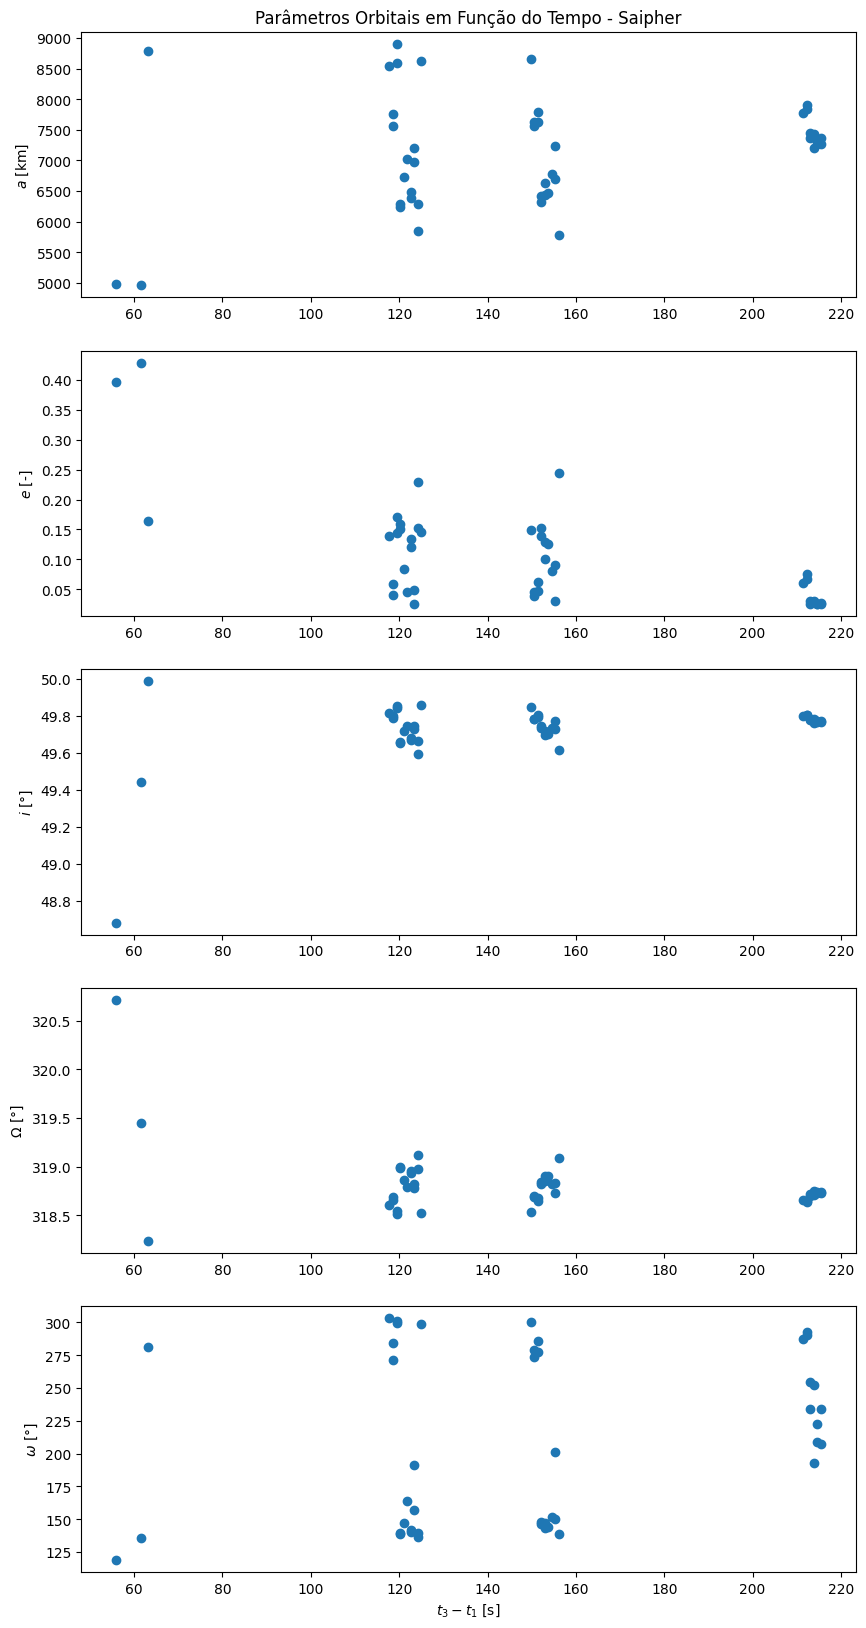

In [ ]:
# Parâmetros Orbitais para a Saipher

# Dados do Observatório da Aldoria:
latitude = -30.5262693  # Latitude geocêntrica do observatório [deg]
longitude = -70.8531799  # [deg]
altitude = 2180e-3  # [km]
latitude_geodetic = np.rad2deg(
    get_geodetic_latitude(latitude)
)  # Latitude geodética do observatório [deg]

# Observações:
tdm_saipher_bruto = tdm_25_filtered
# tdm_saipher_bruto = tdm_30_filtered

# Ajuste dos dados
# tdm_saipher = radec_fit(original_data=tdm_saipher_bruto,poly_degree=3,t_start=tdm_saipher_bruto['Tempo[s]'].min(),t_end=tdm_saipher_bruto['Tempo[s]'].max()+60)
tdm_saipher = tdm_saipher_bruto

n_saipher = len(tdm_saipher["Tempo[s]"])  # Quantidade de observações realizadas

# Parâmetros:
dt_saipher = []
a_saipher = []
i_saipher = []
omega_saipher = []
w_saipher = []
e_saipher = []

for n in range(2, n_saipher):
    # Posições Analisadas:
    initial_saipher = 0
    middle_saipher = int(n / 2)
    end_saipher = n

    # Parâmetros únicos de cada "TDM":
    t_saipher = [
        tdm_saipher["Tempo[s]"].iloc[initial_saipher],
        tdm_saipher["Tempo[s]"].iloc[middle_saipher],
        tdm_saipher["Tempo[s]"].iloc[end_saipher],
    ]  # Horário das observações utilizadas na IOD [s]
    local_sidereal_time_saipher = [
        sidereal_time(
            longitude=longitude, date=tdm_saipher["Tempo (UTC)"].iloc[initial_saipher]
        ),
        sidereal_time(
            longitude=longitude, date=tdm_saipher["Tempo (UTC)"].iloc[middle_saipher]
        ),
        sidereal_time(
            longitude=longitude, date=tdm_saipher["Tempo (UTC)"].iloc[end_saipher]
        ),
    ]
    RAs_saipher = [
        tdm_saipher["RA[deg]"].iloc[initial_saipher],
        tdm_saipher["RA[deg]"].iloc[middle_saipher],
        tdm_saipher["RA[deg]"].iloc[end_saipher],
    ]
    DECs_saipher = [
        tdm_saipher["DEC[deg]"].iloc[initial_saipher],
        tdm_saipher["DEC[deg]"].iloc[middle_saipher],
        tdm_saipher["DEC[deg]"].iloc[end_saipher],
    ]

    # Estimativa inicial do vetor de estado do objeto (r2,v2):
    r2, v2 = r2v2_from_angles_only_gauss(
        latitude_geodetic=latitude_geodetic,
        altitude=altitude,
        local_sidereal_times=local_sidereal_time_saipher,
        RAs=RAs_saipher,
        DECs=DECs_saipher,
        times=t_saipher,
    )

    # Parâmetros Orbitais:
    h, i, omega, e, w, theta = classic_orbital_elements_from_rv(r2, v2)
    a = semimajor_axis_from_he(h, e)

    # Adição dos Dados Obtidos:
    dt_saipher.append(t_saipher[2] - t_saipher[0])
    a_saipher.append(a)
    i_saipher.append(i)
    omega_saipher.append(omega)
    w_saipher.append(w)
    e_saipher.append(e)

# Criação de Data Frame com os Dados:
orbital_param_saipher = pd.DataFrame(
    data={
        "Delta_t": dt_saipher,
        "a": a_saipher,
        "i": i_saipher,
        "omega": omega_saipher,
        "w": w_saipher,
        "e": e_saipher,
    }
)

# Filtro de Outliers:
orbital_param_saipher.dropna(inplace=True)
orbital_param_saipher.where((orbital_param_saipher["e"] < 0.5), inplace=True)

# Plot dos Resultados:
plt.figure(figsize=(10, 20))
# plt.rcParams['text.usetex'] = True
ax1 = plt.subplot(5, 1, 1)
ax1.scatter(orbital_param_saipher["Delta_t"], orbital_param_saipher["a"])
ax1.set_ylabel("$a$ [km]")
ax1.set_title("Parâmetros Orbitais em Função do Tempo - Saipher")
ax2 = plt.subplot(5, 1, 2)
ax2.scatter(orbital_param_saipher["Delta_t"], orbital_param_saipher["e"])
ax2.set_ylabel("$e$ [-]")
ax3 = plt.subplot(5, 1, 3)
ax3.scatter(orbital_param_saipher["Delta_t"], orbital_param_saipher["i"])
ax3.set_ylabel("$i$ [°]")
ax4 = plt.subplot(5, 1, 4)
ax4.scatter(orbital_param_saipher["Delta_t"], orbital_param_saipher["omega"])
ax4.set_ylabel("$\\Omega$ [°]")
ax5 = plt.subplot(5, 1, 5)
ax5.scatter(orbital_param_saipher["Delta_t"], orbital_param_saipher["w"])
ax5.set_ylabel("$\\omega$ [°]")
ax5.set_xlabel("$t_3 - t_1$ [s]")
plt.show()

In [ ]:
orbital_param_saipher.describe()
df_saipher = orbital_param_saipher[orbital_param_saipher.e < orbital_param_saipher.describe().e['25%']]
df_saipher.describe()

,Delta_t,a,i,omega,w,e
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,194.869513,7333.306792,49.769762,318.730190,224.784592,0.028352
std,34.138390,110.822069,0.010008,0.022486,27.293812,0.003896
min,123.413742,7207.978436,49.747332,318.701847,191.369961,0.025213
25%,184.213844,7251.922387,49.765002,318.712987,204.270546,0.025881
50%,213.882407,7317.335700,49.770546,318.732155,222.247072,0.026093
75%,214.682948,7397.207527,49.777684,318.741600,243.310268,0.029761
max,215.483490,7556.692386,49.781819,318.776959,273.340049,0.038569


Conclui-se portanto que a melhor forma de cálculo ocorre para um maior campo de visão (1.5) e um menor Threshold (2.5).